# Analysis of methylation patterns in cancer samples using SOM
by GSDPI *Grupo de Supervisión Diagnóstico y Descubrimiento del Conocimiento en Procesos de Ingeniería*

Universidad de Oviedo, 2024

Paper submitted to ESANN 2024

*"Analysis of DNA methylation patterns in cancer samples using SOM"*

Ignacio Díaz $^1$, José M. Enguita $^1$, Diego García $^1$, Abel A. Cuadrado $^1$, Nuria Valdés $^2$, María D. Chiara $^3$


Affiliations
- $^1$ University of Oviedo - Dept of Electrical Engineering Edificio Torres Quevedo, módulo 2, Campus de Gijón 33204  - SPAIN.
- $^2$ Department of Endocrinology and Nutrition, Hospital Universitario Cruces, Bilbao, Bizkaia. Biobizkaia, CIBERER, CIBERDEM, EndoERN.
- $^3$ Institute of Sanitary Research of the Principado de Asturias Hospital Universitario Central de Asturias, Oviedo 33011 - SPAIN.



**Description**. In this demo we analyze the methylation profiles of more than 390K valid CpG sites in 187 PCPG samples using the *self-organizing map* (SOM) algorithm to obtain 187 component planes that are visual epigenetic signatures of the PCPG tumors. We arranged these SOM planes spatially according to their methylation similarities, and labeled the tumors presenting mutations related to pseudohypoxia conditions, involved in PCPG development and progression. The results reveal cluster structure for these tumors, providing evidences of epigenetic mechanisms involved and suggesting our approach as a complementary analysis tool.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import display, HTML
from basicsom import *

random_state = 42
np.random.seed(random_state)

DATAPATH = "../../Datasets/datos de metilación TCGA (PCPG)/"

# reading methylation data
df = pd.read_hdf(DATAPATH + 'TCGA-PCPG.methylation450.h5')

# reading map to genes
df_rosetta = pd.read_csv(DATAPATH + 'illuminaMethyl450_hg38_GDC.csv', sep='\t')

bases = df_rosetta['#id']
genes = df_rosetta['gene']


print('original dataset')
print(f'bases: {df.shape[0]}')
print(f'samples: {df.shape[1]-1}')

# sample labels (the first column is not a sample)
sample_labels = df.columns.tolist()[1:]

# eliminando nans
df.dropna(inplace=True)

# create a numpy array of shape (bases,samples)
X_beta = df.iloc[:,1:].values

print('')
print('dataset after curating (dropping nans)')
print(f'bases: {df.shape[0]}')
print(f'samples: {df.shape[1]-1}')


original dataset
bases: 485577
samples: 187

dataset after curating (dropping nans)
bases: 391529
samples: 187


## Transform data to gain sensitivity 

Beta values are comprised in the range $[0,1]$ and statistically highly saturated around $0$ and $1$, distributed in a $s$-shaped way. Along with the high dimensionality of the data, this leads to suboptimal performance of the SOM to discriminate methylation patterns with very close $\beta$ values.

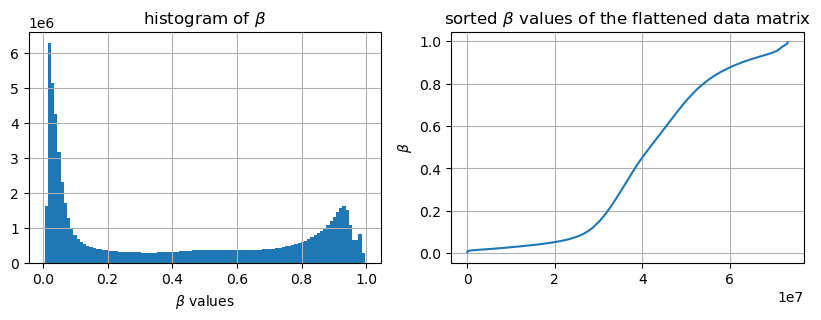

In [2]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title('histogram of $\\beta$')
plt.hist(X_beta.ravel(),bins=100)
plt.xlabel('$\\beta$ values')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.sort(X_beta.ravel()))
plt.title('sorted $\\beta$ values of the flattened data matrix')
plt.ylabel('$\\beta$')
plt.grid(True)
plt.savefig('figures/histogram_betas.pdf')

print()

# Rank normalization
To overcome this, *rank normalization* is proposed. Rank normalization maps each value of $X$ to its *rank* in the flattened matrix(*rank* = position in a sorted list of all $\beta$ values). In our case the rank is scaled to range in the interval $[0,1]$. Rank normalization has some nice properties:
- it is a monothonic transformation
- produces a flat (uniform) histogram, i.e. it equalizes the histogram

In [3]:
# get the rank for each beta value in X_beta
rank_betas = pd.DataFrame(X_beta.ravel()).rank().values

# reshape back the rank_betas array to the shape of X_beta and scale to [0,1]
X = rank_betas.reshape(X_beta.shape)/rank_betas.max()

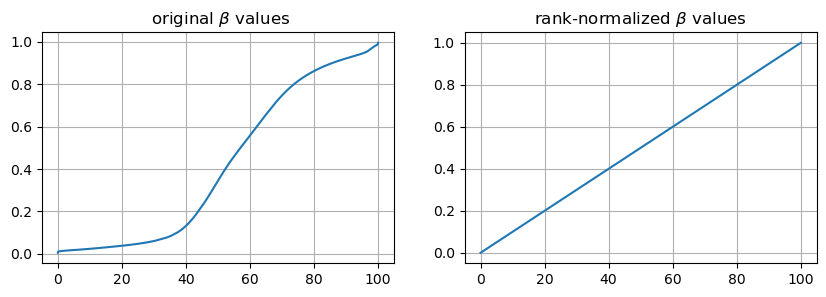

In [4]:
# center figures
display(HTML("<style>.output{display:flex;justify-content:center;}</style>"))


plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,100,np.prod(X_beta.shape)),np.sort(X_beta.ravel()))
plt.title(' original $\\beta$ values')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(np.linspace(0,100,np.prod(X.shape)),np.sort(X.ravel()))
plt.title('rank-normalized $\\beta$ values')
plt.grid(True)
plt.savefig('figures/distribution_betas_and_rank_rormalized.pdf')



Now we can plot the histogram of the original $\beta$ values and the histogram of the rank-normalized $\beta$ values

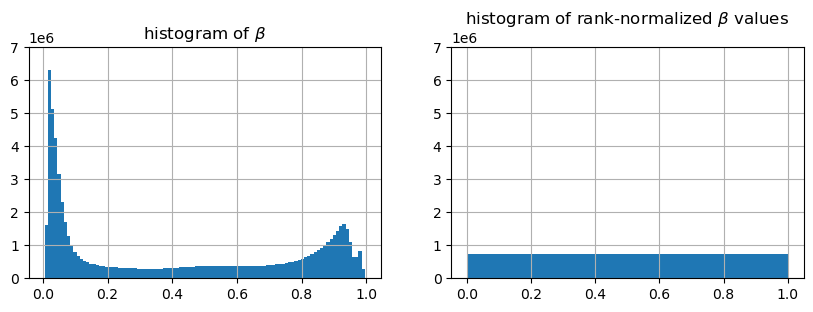

In [5]:
plt.figure(figsize=(10,3))

# original beta values
plt.subplot(1,2,1)
plt.title('histogram of $\\beta$')
plt.hist(X_beta.ravel(),bins=100)
plt.axis(ymax=7e6)
plt.grid(True)

# rank-normalized beta values
plt.subplot(1,2,2)
plt.title('histogram of rank-normalized $\\beta$ values')
plt.hist(X.ravel(),bins=100)
plt.axis(ymax=7e6)
plt.grid(True)
plt.savefig('figures/histogram_betas_and_rank_normalized.pdf')
print()


## SOM training

In [6]:

# EXPERIMENT PARAMETERS

ni,nj = (50,50)					# size of the SOM grid
n_iter = 2000					# number of epochs
batch_size = 300				# size of the minibatches

# neighborhood per epoch
nc = np.logspace(np.log10(20),np.log10(.5), n_iter)

# momentum factor per epoch
t  = np.linspace(0,1,n_iter)
lc = (1 - np.exp(-5*t))


# initialize SOM
gi,mi = inisom(X,[ni,nj])

# random initialization of SOM weights
mi_ = np.random.randn(*mi.shape)

# time statistics
before = time.time()

for i in range(n_iter):
	# minibatch of "batch_size" elements
	idx = np.random.permutation(X.shape[0])[:batch_size]
	xbatch = X[idx,:]

	L = lc[i]
	neigh = nc[i]

	# training step with the minibatch; the current SOM state is updated by the call to bsom()
	mi,mse = bsom(xbatch,gi,mi,neigh)
	# mi,mse = csom(xbatch,gi,mi,neigh)

	# "moment" smooth learning: the weights of the last minibatch are smoothly added to the general weights
	mi_ = L*mi_ + (1-L)*mi
	mi = mi_.copy()

	# show evolution
	if i%50==0:
		print(f'epoch={i}/{n_iter},\t neigh={neigh:.02f},\t momentum={L:.02f},\t mse={mse:.02f},\t dt={time.time()-before:.02f}')
		before = time.time()



epoch=0/2000,	 neigh=20.00,	 momentum=0.00,	 mse=175.06,	 dt=0.08
epoch=50/2000,	 neigh=18.24,	 momentum=0.12,	 mse=2.07,	 dt=3.67
epoch=100/2000,	 neigh=16.63,	 momentum=0.22,	 mse=1.94,	 dt=3.61
epoch=150/2000,	 neigh=15.16,	 momentum=0.31,	 mse=1.93,	 dt=3.60
epoch=200/2000,	 neigh=13.83,	 momentum=0.39,	 mse=1.69,	 dt=3.63
epoch=250/2000,	 neigh=12.61,	 momentum=0.46,	 mse=1.51,	 dt=3.61
epoch=300/2000,	 neigh=11.50,	 momentum=0.53,	 mse=1.50,	 dt=3.63
epoch=350/2000,	 neigh=10.48,	 momentum=0.58,	 mse=1.41,	 dt=3.62
epoch=400/2000,	 neigh=9.56,	 momentum=0.63,	 mse=1.46,	 dt=3.64
epoch=450/2000,	 neigh=8.72,	 momentum=0.68,	 mse=1.37,	 dt=3.62
epoch=500/2000,	 neigh=7.95,	 momentum=0.71,	 mse=1.22,	 dt=3.61
epoch=550/2000,	 neigh=7.25,	 momentum=0.75,	 mse=1.22,	 dt=3.61
epoch=600/2000,	 neigh=6.61,	 momentum=0.78,	 mse=1.16,	 dt=3.62
epoch=650/2000,	 neigh=6.03,	 momentum=0.80,	 mse=1.13,	 dt=3.61
epoch=700/2000,	 neigh=5.50,	 momentum=0.83,	 mse=1.10,	 dt=3.61
epoch=750/2000,	 n

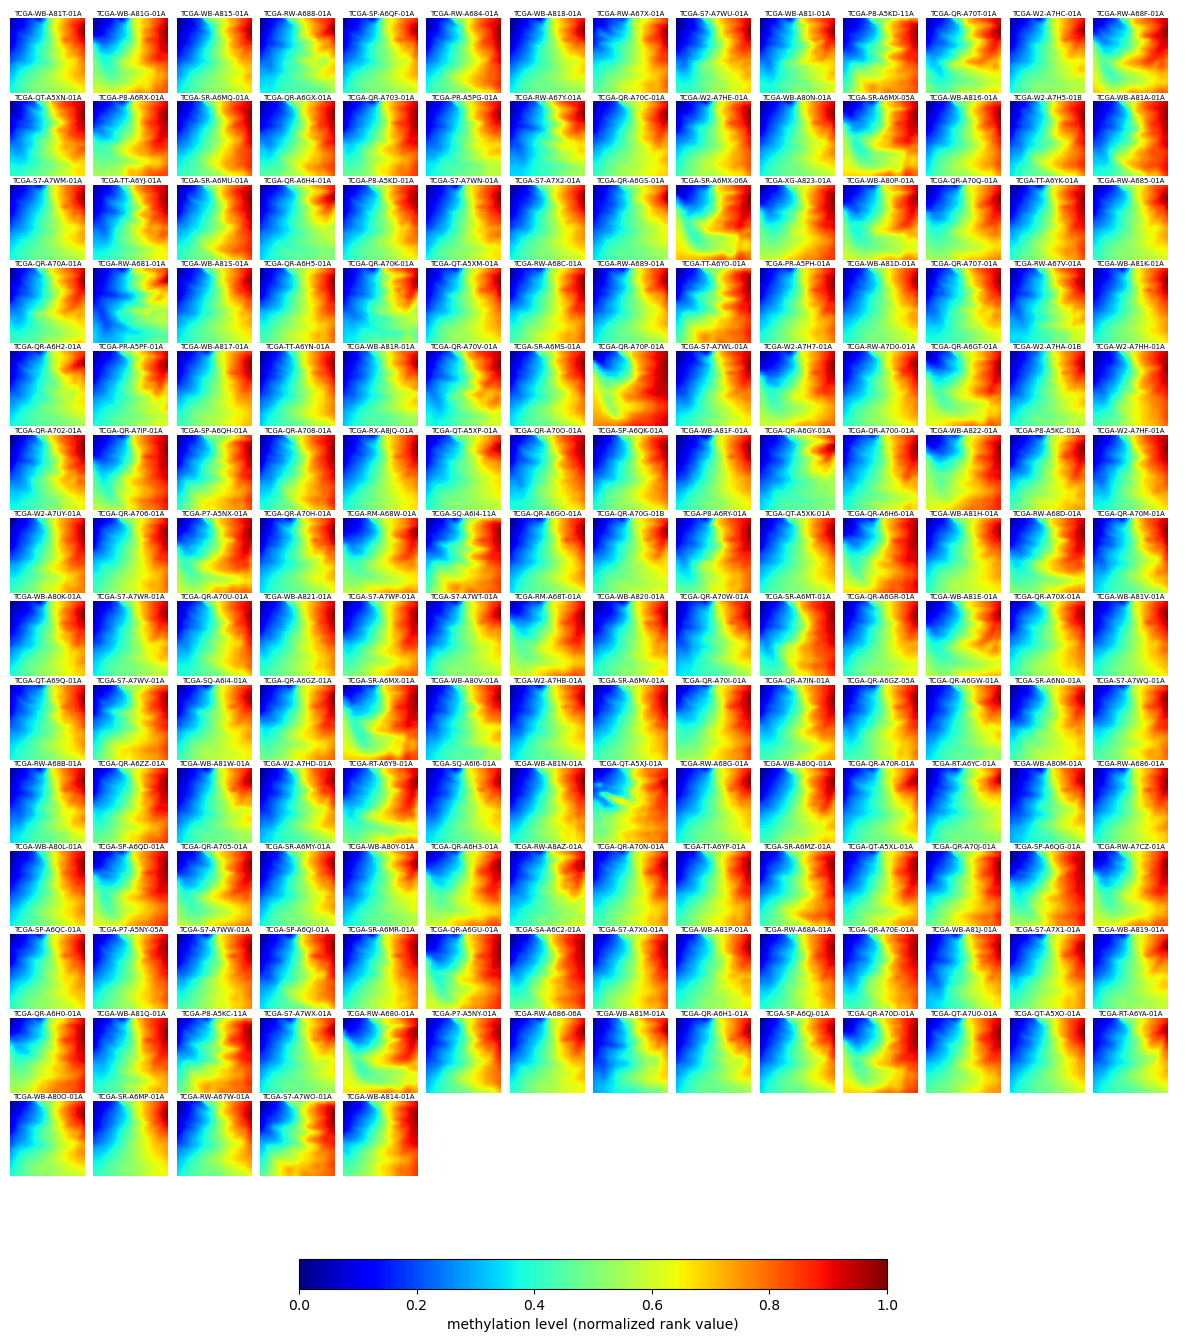

In [7]:
colormap = 'jet'
fig = plt.figure(figsize=(15,15))
ax = fig.subplots()
[ii,jj]=np.meshgrid(np.arange(14),np.arange(14,0,-1))
pos = np.column_stack((ii.reshape(-1,1),jj.reshape(-1,1)))

for i in range(187):
    img = mi[:,i].reshape(ni,nj)
    ii = pos[i,0]
    jj = pos[i,1]
    ax.imshow(img, extent=np.array([ii, ii+.9, jj, jj+.9]).ravel(), origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.text(ii+0.45,jj+.925,f'{sample_labels[i]}',fontsize=5,horizontalalignment='center')
ax.set_xlim([0,14])
ax.set_ylim([0,15])


plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
plt.colorbar(shrink=0.4, location='bottom', pad=0.0, label='methylation level (normalized rank value)')
plt.axis('Off')

plt.tight_layout()



plt.savefig('figures/component_planes_1.pdf',bbox_inches='tight')

## Find location of bases from specific genes
We can locate the CpG sites `cgxxxxxxx` that correspond to specific genes of interest, and find their locations in the SOM map. Particularly we are interested in protocadherines, which are known to be related to pheochromocytome cancer processes


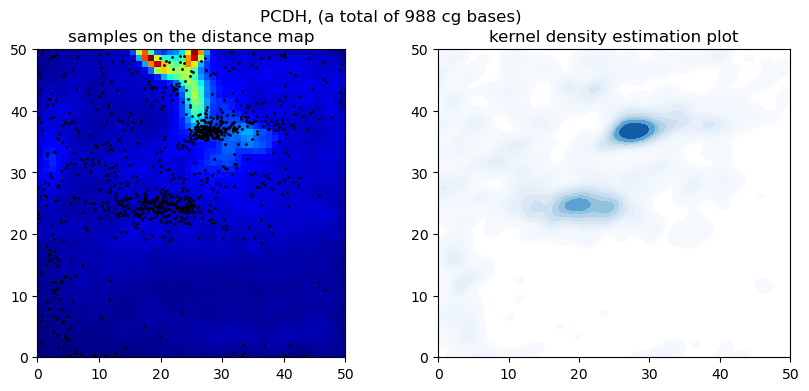

In [8]:
d = somdist_squared_som(mi,ni)


genes_of_interest = ['PCDH']
base_list = []
for gene in genes_of_interest:
	base_list.append([bases[i] for i,v in enumerate(genes) if gene in v ])
	
base_list = [item for sublist in base_list for item in sublist]

idx = np.where(df['Composite Element REF'].isin(base_list))[0]


pr = fproj(X[idx,:],gi,mi,dither=True)[2]
fig = plt.figure(figsize=(10,4))
fig.suptitle(f"{''.join(genes_of_interest)}, (a total of {len(idx)} cg bases)")
plt.subplot(1,2,1)
plt.imshow(d.reshape(ni,nj), extent=[0,ni,0,nj], origin='lower', cmap=colormap)
plt.scatter(pr[:,0],pr[:,1],s=1,color='black')
plt.title('samples on the distance map')
plt.axis([0,50,0,50])

import seaborn as sns
plt.subplot(1,2,2)
sns.kdeplot(x=pr[:,0], y=pr[:,1], cmap="Blues", levels=15, fill=True, bw_adjust=0.3)
plt.axis([0,50,0,50])
plt.title('kernel density estimation plot')
plt.savefig('figures/pcdh_projection.pdf')


PCDH, (a total of 988 CG bases)


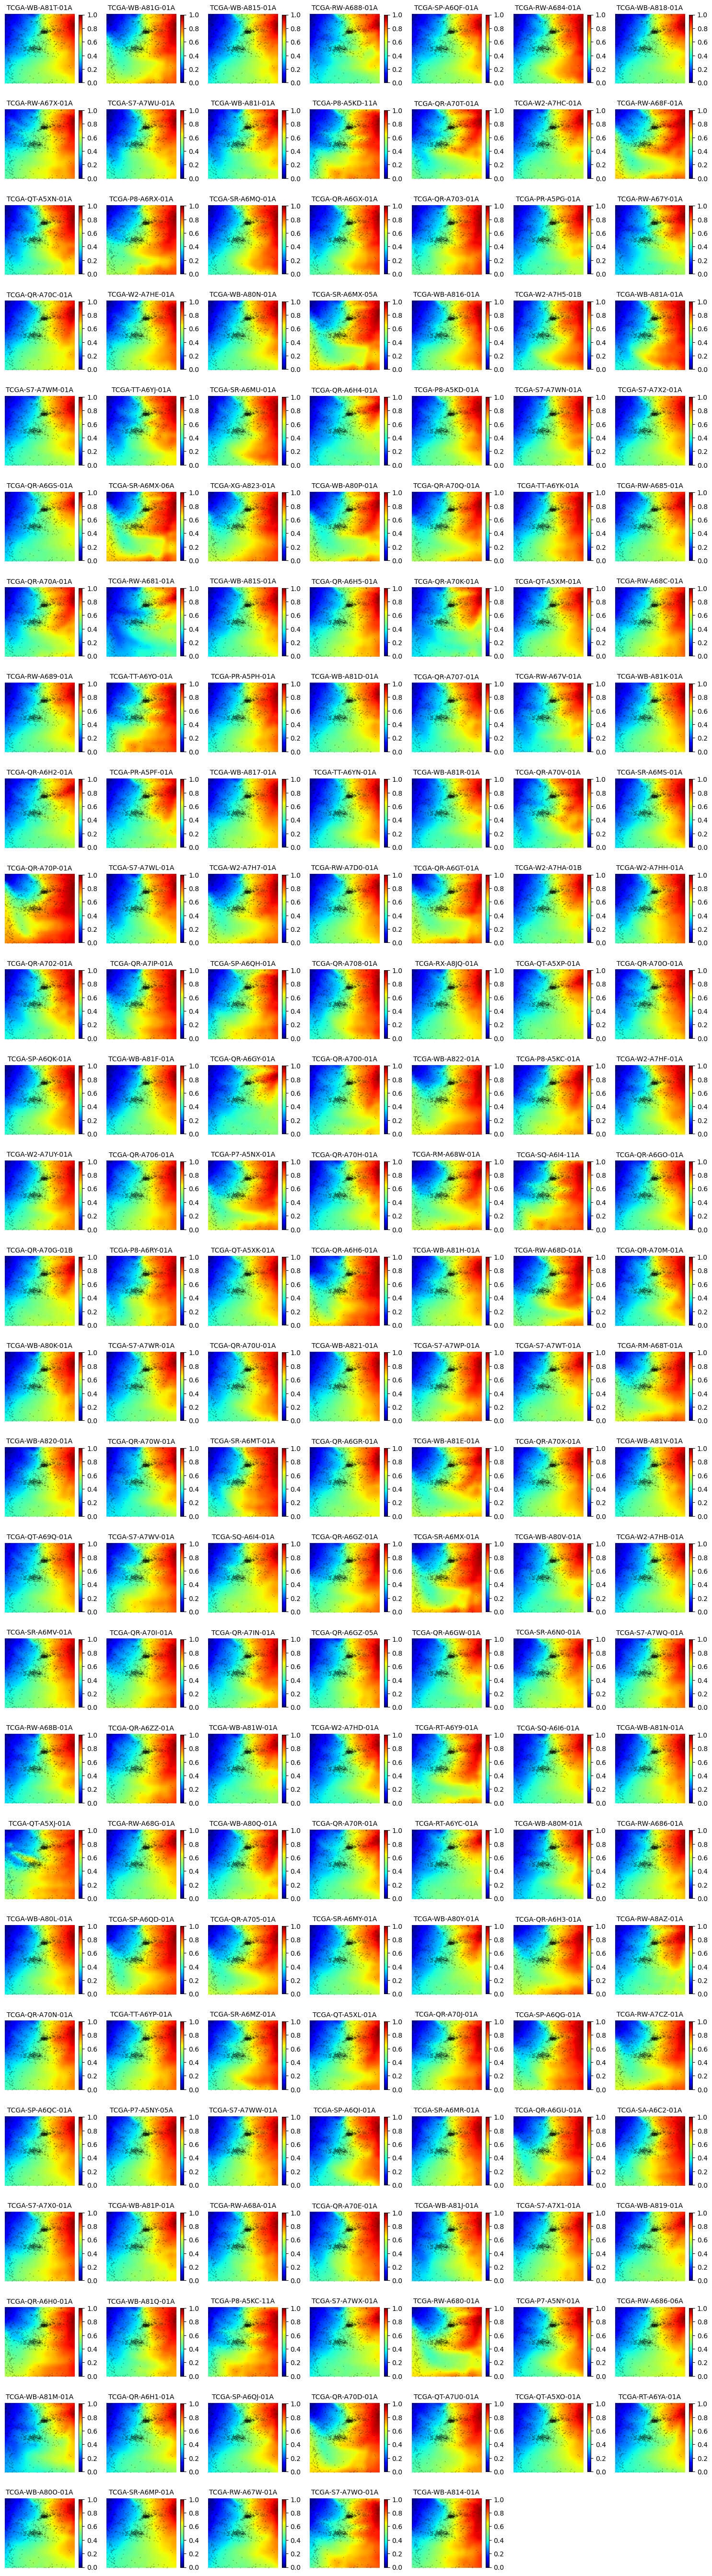

In [9]:
fig = plt.figure(figsize=(15,60))
print(f"{''.join(genes_of_interest)}, (a total of {len(idx)} CG bases)")

for i in range(187):
    img = mi[:,i].reshape(ni,nj)
    plt.subplot(30,7,i+1)
    plt.imshow(img, origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.colorbar(shrink=0.8)
    plt.scatter(pr[:,0],pr[:,1],s=.5,color='black',alpha=0.2)
    plt.title(f'{sample_labels[i]}',fontsize=10)
    plt.axis('Off')

plt.tight_layout()
plt.savefig('figures/component_planes_2.pdf')

/var/folders/kl/1v2yl4xd5fj999gkvkbg3j0w0000gn/T/ipykernel_43735/1901140866.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
/var/folders/kl/1v2yl4xd5fj999gkvkbg3j0w0000gn/T/ipykernel_43735/1901140866.py:18: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)


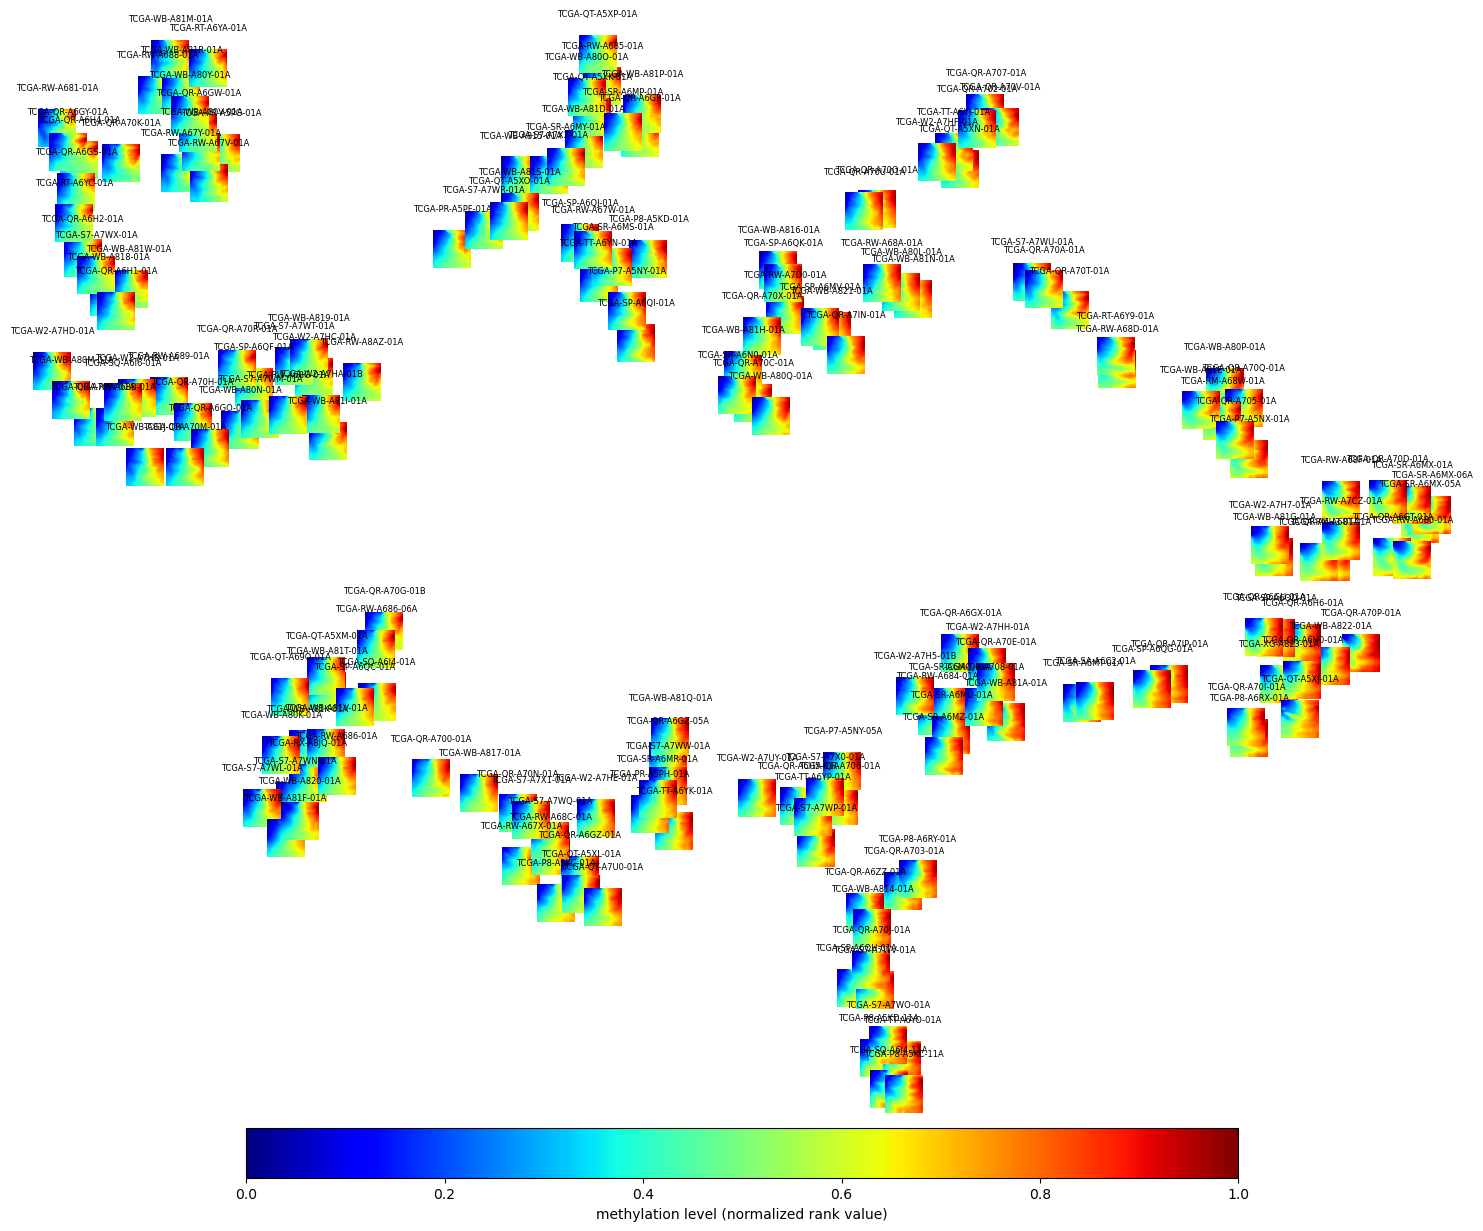

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=5)
pr=tsne.fit_transform(mi.T)
pr = pr*0.7


fig = plt.figure(figsize=(15,15))
ax = fig.subplots()
# fig, ax = plt.subplots()
for i in range(pr.shape[0]):
    img = mi[:,i].reshape(ni,nj)
    ax.imshow(img, extent=np.array([pr[i,0]-1,pr[i,0]+1,pr[i,1]-1,pr[i,1]+1]).ravel(), origin='lower', cmap=colormap, vmin=0, vmax=1)
    plt.text(pr[i,0],pr[i,1]+2,sample_labels[i],fontsize=6,horizontalalignment='center')

# plt.imshow(np.array([[1]]), extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
# plt.colorbar(shrink=0.5)
# plt.axis('Off')
plt.imshow(np.array([[1]]),extent=[0,0,0,0], vmin=0,vmax=1,cmap=colormap)
plt.colorbar(shrink=0.7, location='bottom', pad=0.01, label='methylation level (normalized rank value)')
plt.axis('Off')

# a "ghost" scatter forces the image to autoscale
ax.scatter(pr[:,0],pr[:,1],s=0)

plt.tight_layout()
plt.savefig('figures/tsne_projection.pdf',bbox_inches='tight')

pr_tsne = pr.copy()


# Label interesting tumors: mutations in  SDHx, EPAS1, VHL

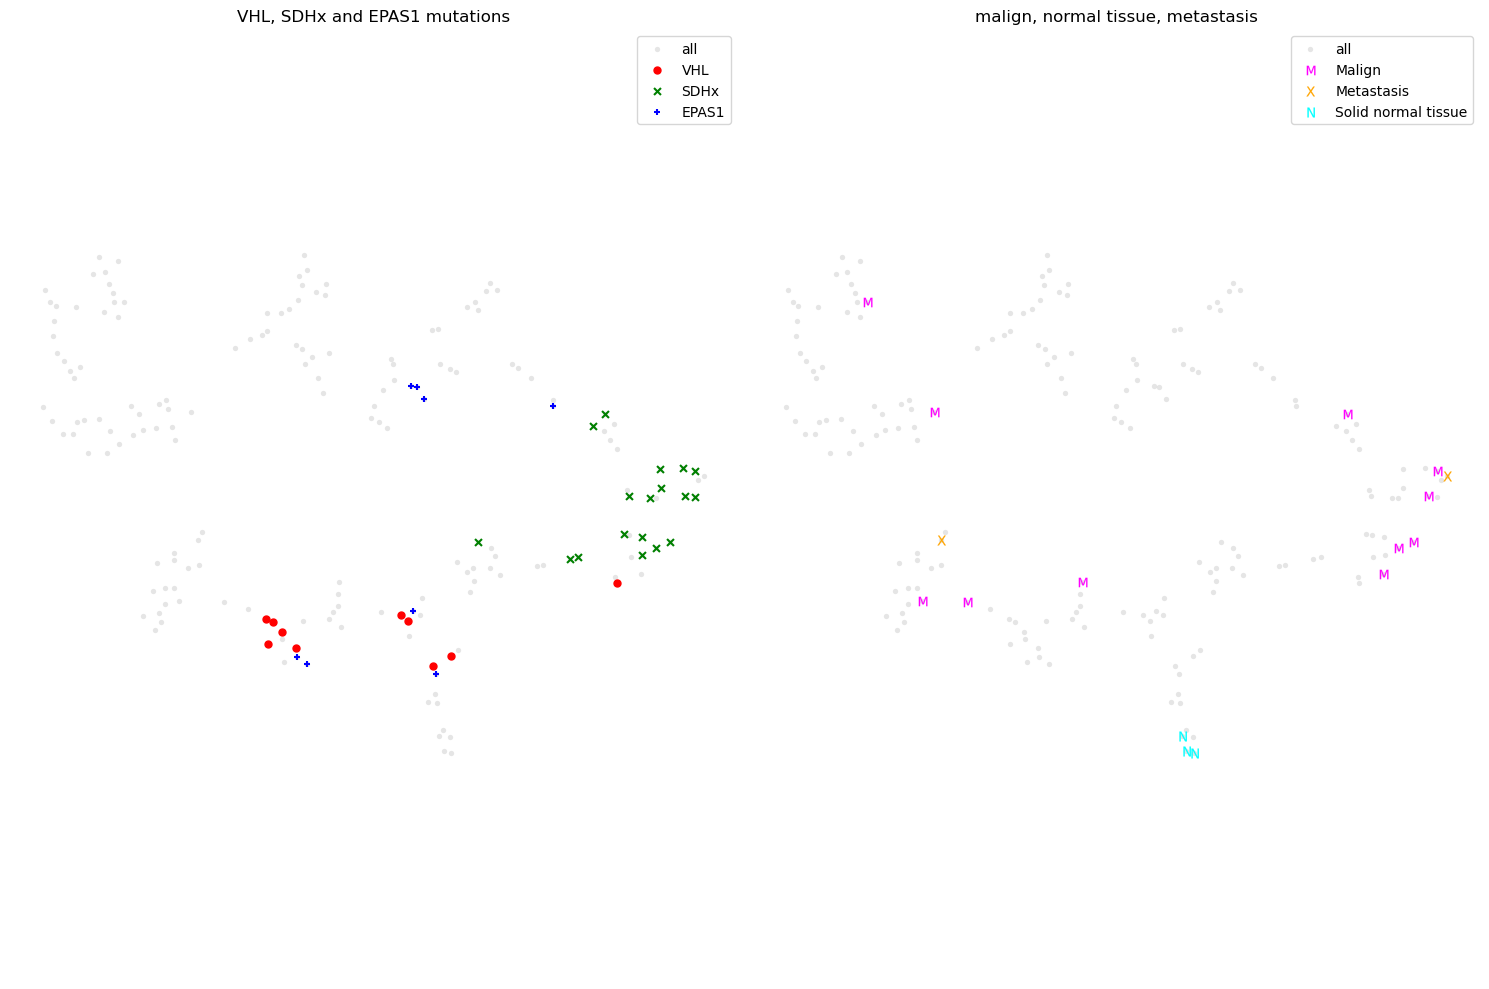

In [11]:
# lists of tumors presenting relevant mutations (in VHL, SDHx, EPAS1 genes)
df_groups = pd.read_csv('groups_mutations.csv')

VHL    = df_groups[df_groups['grupo']=='VHL']['tumor'].values.tolist()
SDHx   = df_groups[df_groups['grupo']=='SDHx']['tumor'].values.tolist()
EPAS1  = df_groups[df_groups['grupo']=='EPAS1']['tumor'].values.tolist()
MALIGN = df_groups[df_groups['grupo']=='Maligno']['tumor'].values.tolist()


idx_vhl = []
idx_sdh = []
idx_epas1 = []
idx_malign = []
idx_metastasis = []
idx_normal = []
for i,v in enumerate(sample_labels):
    if any(i in v for i in VHL):
        idx_vhl.append(i)
    if any(i in v for i in SDHx):
        idx_sdh.append(i)
    if any(i in v for i in EPAS1):
        idx_epas1.append(i)
    if any(i in v for i in MALIGN):
        idx_malign.append(i)
    if '-06' in v:
        idx_metastasis.append(i)
    if '-11' in v:
        idx_normal.append(i)



plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.scatter(pr_tsne[:,0],pr_tsne[:,1],s=15,color='black',alpha=0.1,linewidths=0)
plt.scatter(pr_tsne[idx_vhl,0],pr_tsne[idx_vhl,1],s=25,color='red',marker='o')
plt.scatter(pr_tsne[idx_sdh,0],pr_tsne[idx_sdh,1],s=25,color='green',marker='x')
plt.scatter(pr_tsne[idx_epas1,0],pr_tsne[idx_epas1,1],s=25,color='blue',marker='+')
plt.axis('equal')
plt.axis('off')
plt.title('VHL, SDHx and EPAS1 mutations')
plt.legend(['all','VHL','SDHx','EPAS1'])
plt.subplot(1,2,2)
plt.scatter(pr_tsne[:,0],pr_tsne[:,1],s=15,color='black',alpha=0.1,linewidths=0)
plt.scatter(pr_tsne[idx_malign,0],pr_tsne[idx_malign,1],s=50,color='magenta',marker='$\\rm M$',linewidths=0.1)
plt.scatter(pr_tsne[idx_metastasis,0],pr_tsne[idx_metastasis,1],s=50,color='orange',marker='$\\rm X$',linewidths=0.1)
plt.scatter(pr_tsne[idx_normal,0],pr_tsne[idx_normal,1],s=50,color='cyan',marker='$\\rm N$',linewidths=0.1)
plt.legend(['all','Malign','Metastasis','Solid normal tissue'])
# plt.legend(['all','VHL','SDHx','EPAS1','Malign','Metastasis','Solid normal tissue'])
plt.title('malign, normal tissue, metastasis')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/tsne_samples_with_vhl_sdh_epas1_mutations.pdf')
plt.show()
